# A Classification Problem
### Predicting Bank Customer Churn 
This project idea came to me through participation in a scholarship by the Datum Discovery organization. I had the privilege of being selected for their scholarship program, which required me to showcase my creativity by developing a Power BI Dashboard project based on a Bank Customer Churn dataset. 

I successfully created the dashboard, which is available through this **[Link](https://sabuny.github.io/Bank-Customer-Churn/)** . This is when idea of building a model to predict whether a customer would churn or not came to mind and since the dataset was well suited for this purpose, I decided to explore solving a Classification Problem.
In this project, we will predict whether a customer is likely to stay with the bank or leave. 

#### Defining the Problem
Bank customer churn is a critical issue that can lead to significant revenue loss for financial institutions. Understanding why customers leave the bank and predicting which customers are at risk of churning enables banks to take proactive measures to retain customers. In this project I aim to predict customer churn using a machine learning model
#### Objective
Building a predictive model that identifies customers who are likely to leave the bank by using historical customer data as this will allow the bank to focus on retaining customers who are at risk to leave.

#### Business Impact
Predicting customer churn helps banks:
* Reduce customer acquisition costs: It’s often cheaper to retain existing customers than to acquire new ones.
* Improve customer satisfaction: Banks can identify dissatisfied customers early and take corrective action.
* Increase profitability: Retained customers often generate more lifetime value, leading to better long-term financial performance.


The dataset is available in **[link](https://drive.google.com/file/d/1Ds9yBc0sXitWkfxHKzP6IBaFfGKm9plh/view?usp=sharing)** and includes the following features:
* **CustomerId:** A unique identifier for each customer.
* **Surname:** The customer's last name.
* **Geography:** The country where the customer resides (France, Spain, or Germany).
* **Gender:** The customer's gender (Male or Female).
* **Age:** The customer's age.
* **Tenure:** The number of years the customer has been with the bank.
* **Balance:** The customer's account balance.
* **NumOfProducts:** The number of bank products the customer uses (e.g., savings account, credit card).
* **IsActiveMember:** Whether the customer is an active member (1 = yes, 0 = no).
* **EstimatedSalary:** The customer's estimated salary.
* **Exited:** Whether the customer has churned (1 = yes, 0 = no).


### Data Preprocessing
We'll begin with importing the necessary libraries.

In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score
import time
import joblib
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,roc_curve,roc_auc_score,auc,f1_score

Lets import our dataset and begin exploring it

In [2]:
#reading our dataset
df =pd.read_csv("Bank_Churn.csv")
display(df.head(4))
print("\nData Types")
print(df.dtypes)
print(f"\nThe shape of the dataset: {df.shape}")
print(f"\nMissing values present: {df.isna().any()}")
print(f"\nDuplicated present: {df.duplicated().any()}")

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0



Data Types
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

The shape of the dataset: (10000, 13)

Missing values present: CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

Duplicated present: False


We can note that our dataset is a tidy data but to be sure we'll do a general cleaning to the numerical features

In [3]:
#lets remove any error values in our numeric columns
def convert_to_numeric(df, column_name, fill_value=0, to_int=False):
    df[column_name] = pd.to_numeric(df[column_name], errors="coerce")
    df[column_name] = df[column_name].fillna(fill_value)
    if to_int:
        df[column_name] = df[column_name].astype(int)
    return df

In [4]:
#passing the function to the numerical features
df =convert_to_numeric(df,"CustomerId",fill_value=0,to_int=True)

df = convert_to_numeric(df, "CreditScore", fill_value=df["CreditScore"].mean())

df=convert_to_numeric(df,"Age",fill_value=df["Age"].mean())

df =convert_to_numeric(df,"Tenure",fill_value=0,to_int=True)

df =convert_to_numeric(df,"Balance",fill_value=df["Balance"].mean())

df =convert_to_numeric(df,"NumOfProducts",fill_value=0,to_int=True)

df= convert_to_numeric(df,"HasCrCard",fill_value=0,to_int=True)

df=convert_to_numeric(df,"IsActiveMember",fill_value=0,to_int=True)

df=convert_to_numeric(df,"EstimatedSalary",fill_value=df["EstimatedSalary"].mean())

df=convert_to_numeric(df,"Exited",fill_value=0,to_int=True)

* lets get a general understanding of our dataset

#### Lets create a pivot table

In [5]:
print(df["NumOfProducts"].sum())

15302


In [6]:
pivot_table =df.pivot_table(
    index="Geography",
    values=["CreditScore","NumOfProducts","Tenure"],
    aggfunc={
    "CreditScore":"mean",
    "NumOfProducts":"sum",
    "Tenure":"mean",
    }
)

pivot_table.columns =["Average Credit Score","Total Products","Average Tenure"]
display(pivot_table)

,Average Credit Score,Total Products,Average Tenure
Geography,,,
France,649.668329,7676,5.004587
Germany,651.453567,3813,5.009964
Spain,651.333872,3813,5.032297


In [7]:
#lets look at how many customers are there
print(f"\nTotal number of Customers: {df["CustomerId"].nunique()}")
print(f"\nCustomers Churned: {df[df["Exited"]==1].shape[0]}")

#calculating churn rate
churn_rate =np.round((df['Exited'].sum() / len(df))*100,0)
print(f"\nChurn Rate: {churn_rate:.0f}%")

print(f"\nAverage Credit Score: {df["CreditScore"].mean():.0f}")
print(f"\nAverage Tenure: {df["Tenure"].mean():.0f}")
print(f"\nCustomers with Credit Cards: {df[df["HasCrCard"]==1].shape[0]}")
print(f"\nThe Number of Products offered by the Bank: {df["NumOfProducts"].nunique()}")
print(f"\nAverage Number of Products of Each Customer: {df["NumOfProducts"].mean():.0f}")
print(f"\nGeographical locations of the Customers: {df["Geography"].unique()}")
print(f"\nActive Members: {df[df["IsActiveMember"]==1].shape[0]}")
print(f"\nOldest Customer Age: {df["Age"].max()}")
print(f"\nYoungest Age: {df["Age"].min()}")


Total number of Customers: 10000

Customers Churned: 2037

Churn Rate: 20%

Average Credit Score: 651

Average Tenure: 5

Customers with Credit Cards: 7055

The Number of Products offered by the Bank: 4

Average Number of Products of Each Customer: 2

Geographical locations of the Customers: ['France' 'Spain' 'Germany']

Active Members: 5151

Oldest Customer Age: 92

Youngest Age: 18


In [8]:
top_customers =df.sort_values(by="Balance",ascending=False)
top_10_customers =top_customers[["Surname","Balance","Geography"]].set_index("Surname").head(10)
display(top_10_customers)

,Balance,Geography
Surname,,
Lo,250898.09,Spain
To Rot,238387.56,France
Haddon,222267.63,Spain
McIntosh,221532.80,Spain
Shaw,216109.88,Spain
Dilke,214346.96,Germany
Chia,213146.20,Spain
Moore,212778.20,France
Thomson,212696.32,Germany


### Insights
* The bank serves 10,000 customers across three main geographical locations: France, Spain and Germany.
*  The average credit score of the bank's customers is 651 indicating a moderate credit profile. 
* On average, customers have been with the bank for 5 years showing a fair level of customer loyalty. 
*  The bank offers 4 products. On average, each customer uses 2 products, suggesting potential for expanding product usage through targeted marketing or personalized offers.
* 7,055 customers hold a credit card with the bank which creates an opportunity to cross sell other products to this large segment.
* From the total number of customers 5,151 customers are as active members indicating that around half of the customers are actively engaged with the bank.
* The age range of the bank’s customers varies significantly with the youngest customer being 18 and the oldest 92 years old. This wide range indicates that the bank caters to both younger and older customers.
* France has a higher engagement in terms of total products possibly indicating a larger customer base or higher product usage per customer compared to Germany and Spain.
* Germany and Spain show nearly identical credit scores, total products and tenures suggesting similar customer behavior in these two regions.
* The similarity in average tenure across all three regions suggests that the bank's customers tend to stay with the bank for a similar length of time.
* Spain is the country with the largest representation in the top 10, indicating that customers in Spain tend to hold higher balances compared to those in Germany and France. 

#### Data Transformation
I will begin my creating two new columns for Age,Salary and Credit Score for easier analysis.

**Age group** with values Young, Middle and Old 

**Credit Category** with values Low Medium and High

**Salary Range** with values <20K,20K-50K,50K-100K,100K-150K and 150K-200K

In [9]:
#lets create Age groups
def age_group(age):
    if age < 30:
        return "Young"
    elif 30 <= age < 60:
        return "Middle"
    else:
        return "Old"

df["Age Group"] =df["Age"].apply(age_group)

In [10]:
#lets create tiers of credit score
def credit_group(credit):
    if credit < 500:
        return "Low"
    elif 500 <= credit < 700:
        return "Medium"
    else:
        return "High"

df["Credit category"]=df["CreditScore"].apply(credit_group)

In [11]:
#lets create salary range
bins =[0, 20_000, 50_000, 100_000, 150_000, 200_000]
labels =["<20K","20K-50K","50K-100K","100K-150K","150K-200K"]
df["Salary Range"] =pd.cut(df["EstimatedSalary"],bins=bins, labels=labels, include_lowest=True)

* lets view our new modified dataset

In [12]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age Group,Credit category,Salary Range
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Middle,Medium,100K-150K
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Middle,Medium,100K-150K
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Middle,Medium,100K-150K
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Middle,Medium,50K-100K
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Middle,High,50K-100K


## Exploratory Data Analysis
Lets do some statistical analysis to get a better understanding of our data through visualizations and summary statistics.

* Lets visualize **distribution of churned customers by Gender**

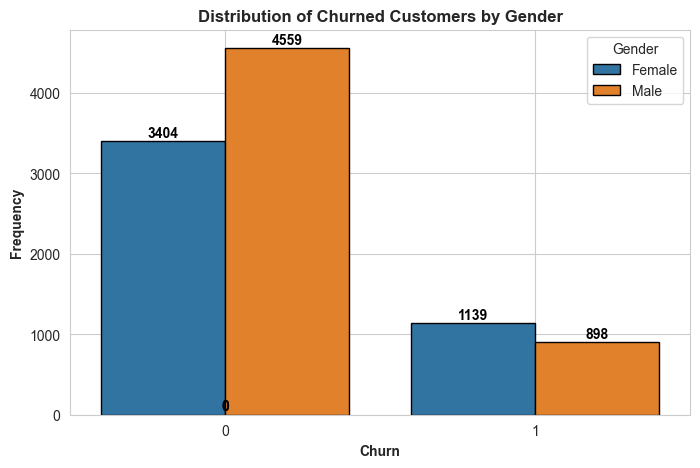

In [13]:
count =df["Exited"].value_counts(ascending=False)
order =count.index
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
ax=sns.countplot(data=df, x="Exited",order=order, hue="Gender",edgecolor="black")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", 
                va="baseline", 
                fontsize=10, 
                color="black", 
                xytext=(0, 3),
                textcoords="offset points",
                fontweight="bold")
plt.title("Distribution of Churned Customers by Gender", fontsize=12, fontweight="bold")
plt.xlabel("Churn", fontsize=10, fontweight="bold")
plt.ylabel("Frequency", fontsize=10, fontweight="bold")
plt.grid(True, linestyle="solid")
plt.show()

We can note that females have a significantly higher churn rate compared to male customers even though male customers more in total.
Lets see if there are any patterns in age or how the female customers have been in the bank

* Lets visualize **geographical distribution of customers**

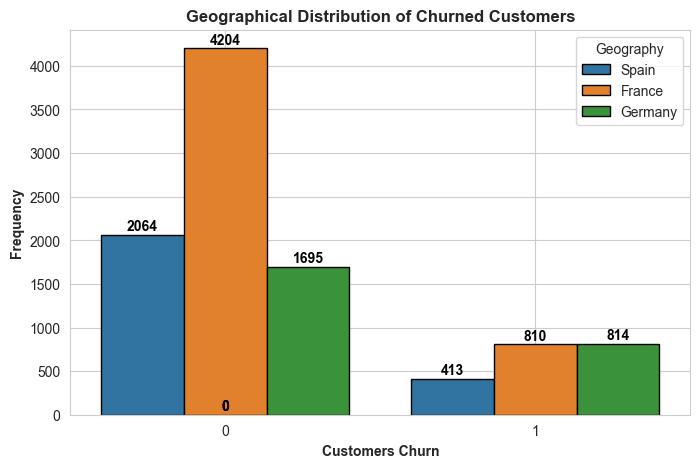

In [14]:
count=df["Exited"].value_counts(ascending=False)
order =count.index
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
ax=sns.countplot(data=df, x="Exited",hue="Geography",order=order,edgecolor="black")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", 
                va="baseline", 
                fontsize=10, 
                color="black", 
                xytext=(0, 3),
                textcoords="offset points",
                fontweight="bold")
plt.title("Geographical Distribution of Churned Customers", fontsize=12, fontweight="bold")
plt.xlabel("Customers Churn", fontsize=10, fontweight="bold")
plt.ylabel("Frequency", fontsize=10, fontweight="bold")
plt.grid(True, linestyle="solid")
plt.show()

* Lets look at the **distribution of active churned customers geographically**

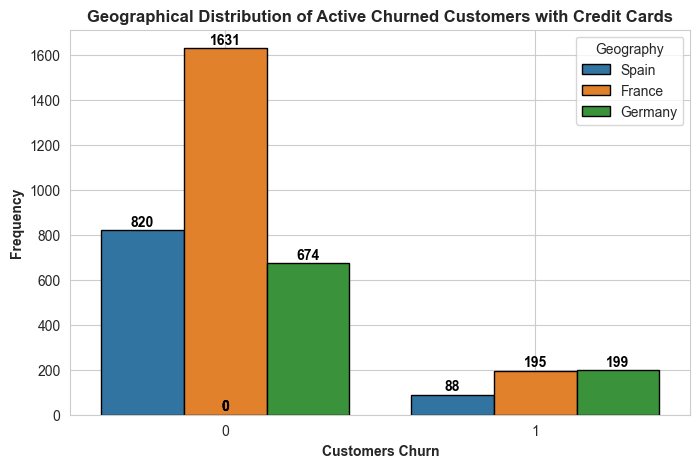

In [15]:
new_df =df[(df["HasCrCard"]==1) &(df["IsActiveMember"])]
count=df["Exited"].value_counts(ascending=False)
order =count.index
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
ax=sns.countplot(data=new_df, x="Exited",hue="Geography",order=order,edgecolor="black")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", 
                va="baseline", 
                fontsize=10, 
                color="black", 
                xytext=(0, 3),
                textcoords="offset points",
                fontweight="bold")
plt.title("Geographical Distribution of Active Churned Customers with Credit Cards", fontsize=12, fontweight="bold")
plt.xlabel("Customers Churn", fontsize=10, fontweight="bold")
plt.ylabel("Frequency", fontsize=10, fontweight="bold")
plt.grid(True, linestyle="solid")
plt.show()

* Lets plot a **line graph of Tenure vs Churn Count**

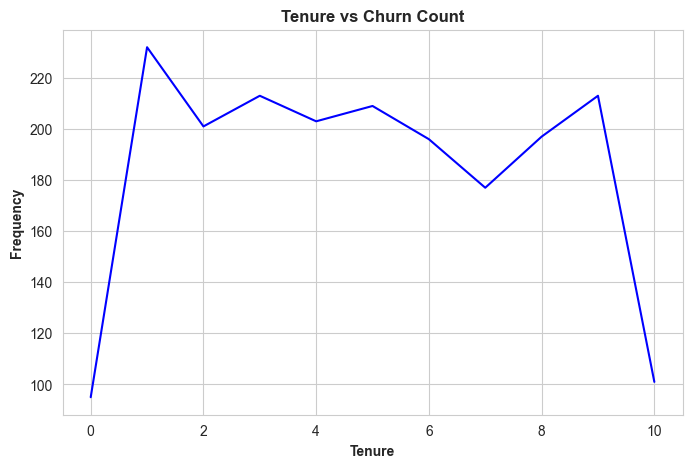

In [16]:
new_df = df.groupby("Tenure")["Exited"].sum().reset_index()
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.lineplot(data=new_df, x="Tenure", y="Exited",color="blue")
plt.title("Tenure vs Churn Count",fontsize=12, fontweight="bold")
plt.xlabel("Tenure", fontweight="bold", fontsize=10)
plt.ylabel("Frequency", fontweight="bold", fontsize=10)
plt.grid(True, linestyle="solid")
plt.show()

* Lets visualize **Tenure distribution of churned customers by gender**

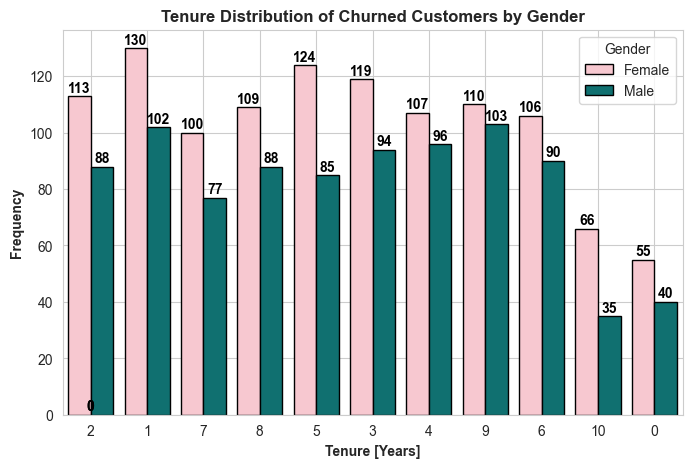

In [17]:
new_df=df[df["Exited"]==1]
count=df["Tenure"].value_counts(ascending=False)
order =count.index
sns.set_style("whitegrid")
palette =sns.set_palette(["pink","teal",])
plt.figure(figsize=(8,5))
ax=sns.countplot(data=new_df, x="Tenure",hue="Gender",palette=palette,order=order,edgecolor="black")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", 
                va="baseline", 
                fontsize=10, 
                color="black", 
                xytext=(0, 3),
                textcoords="offset points",
                fontweight="bold")
plt.title("Tenure Distribution of Churned Customers by Gender", fontsize=12, fontweight="bold")
plt.xlabel("Tenure [Years]", fontsize=10, fontweight="bold")
plt.ylabel("Frequency", fontsize=10, fontweight="bold")
plt.grid(True, linestyle="solid")
plt.show()

* Lets visualize the same with age by **Distribution of Active Churned Customers with Credit Cards by Gender**

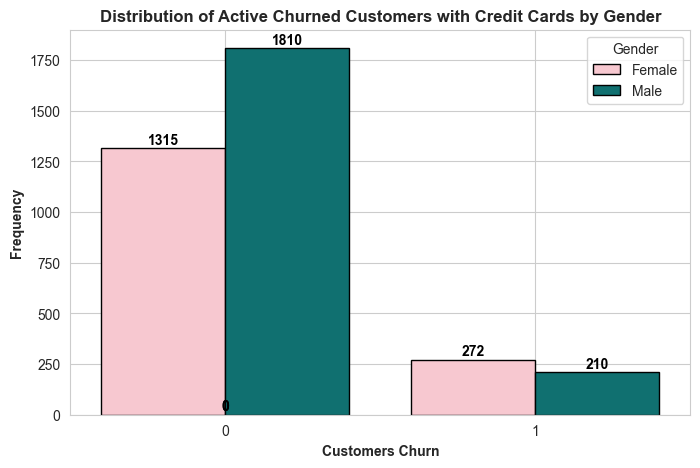

In [18]:
new_df =df[(df["HasCrCard"]==1) &(df["IsActiveMember"])]
count=df["Exited"].value_counts(ascending=False)
order =count.index
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
ax=sns.countplot(data=new_df, x="Exited",hue="Gender",order=order,edgecolor="black")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", 
                va="baseline", 
                fontsize=10, 
                color="black", 
                xytext=(0, 3),
                textcoords="offset points",
                fontweight="bold")
plt.title("Distribution of Active Churned Customers with Credit Cards by Gender", fontsize=12, fontweight="bold")
plt.xlabel("Customers Churn", fontsize=10, fontweight="bold")
plt.ylabel("Frequency", fontsize=10, fontweight="bold")
plt.grid(True, linestyle="solid")
plt.show()

* Lets take a look at **Distribution of Active Churned Customers with Credit Cards by Age Group**

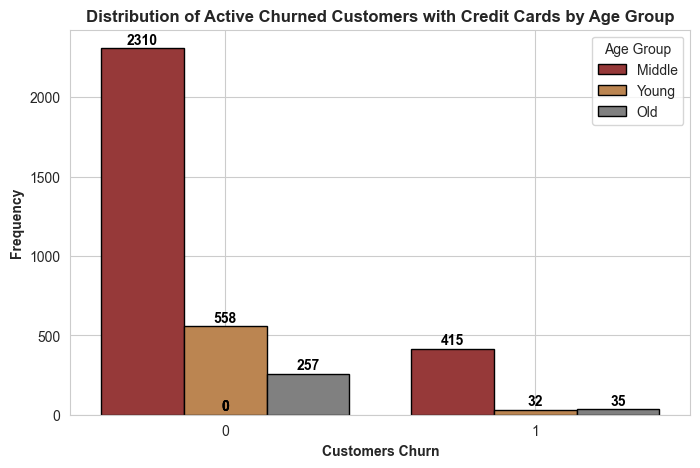

In [19]:
new_df =df[(df["HasCrCard"]==1) &(df["IsActiveMember"])]
count=df["Exited"].value_counts(ascending=False)
order =count.index
sns.set_style("whitegrid")
palette =sns.set_palette(["brown","peru","gray"])
plt.figure(figsize=(8,5))
ax=sns.countplot(data=new_df, x="Exited",hue="Age Group",palette=palette,order=order,edgecolor="black")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", 
                va="baseline", 
                fontsize=10, 
                color="black", 
                xytext=(0, 3),
                textcoords="offset points",
                fontweight="bold")
plt.title("Distribution of Active Churned Customers with Credit Cards by Age Group", fontsize=12, fontweight="bold")
plt.xlabel("Customers Churn", fontsize=10, fontweight="bold")
plt.ylabel("Frequency", fontsize=10, fontweight="bold")
plt.grid(True, linestyle="solid")
plt.show()

* Lets visualize **distribution of customers by creditscore**

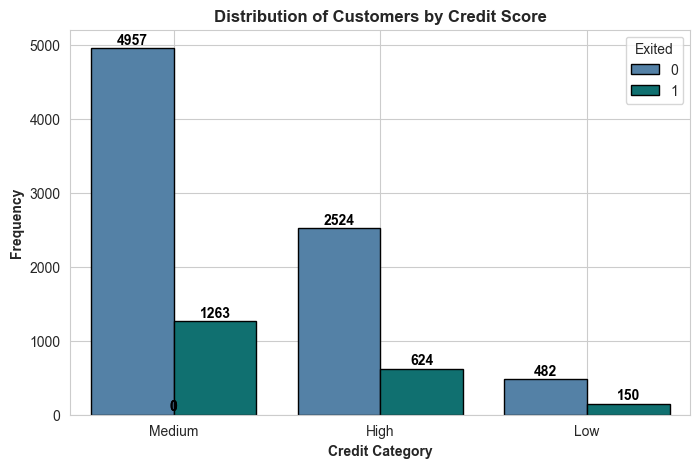

In [20]:
count=df["Credit category"].value_counts(ascending=False)
order =count.index
sns.set_style("whitegrid")
palette =sns.set_palette(["steelblue","teal"])
plt.figure(figsize=(8,5))
ax=sns.countplot(data=df, x="Credit category",order=order,hue="Exited",edgecolor="black")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", 
                va="baseline", 
                fontsize=10, 
                color="black", 
                xytext=(0, 3),
                textcoords="offset points",
                fontweight="bold")
plt.title("Distribution of Customers by Credit Score", fontsize=12, fontweight="bold")
plt.xlabel("Credit Category", fontsize=10, fontweight="bold")
plt.ylabel("Frequency", fontsize=10, fontweight="bold")
plt.grid(True, linestyle="solid")
plt.show()

* Lets visualize **Distribution of Active Churn Customers by Credit Score**

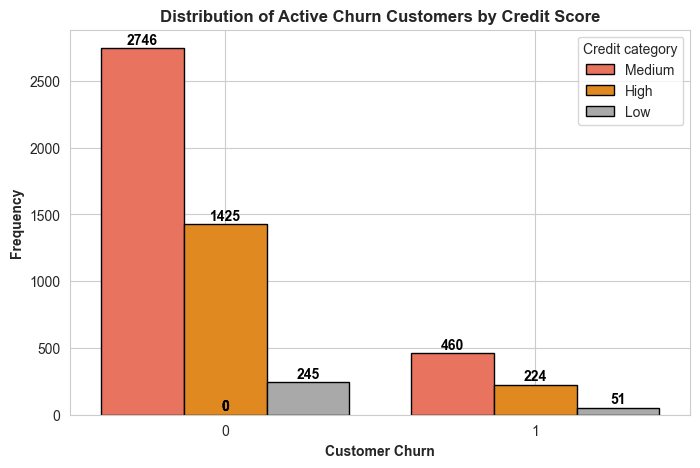

In [21]:
new_df =df[df["IsActiveMember"]==1]
count=df["Exited"].value_counts(ascending=False)
order =count.index
sns.set_style("whitegrid")
palette=sns.set_palette(["tomato","darkorange","darkgray"])
plt.figure(figsize=(8,5))
ax=sns.countplot(data=new_df, x="Exited",order=order,hue="Credit category",edgecolor="black")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", 
                va="baseline", 
                fontsize=10, 
                color="black", 
                xytext=(0, 3),
                textcoords="offset points",
                fontweight="bold")
plt.title("Distribution of Active Churn Customers by Credit Score", fontsize=12, fontweight="bold")
plt.xlabel("Customer Churn", fontsize=10, fontweight="bold")
plt.ylabel("Frequency", fontsize=10, fontweight="bold")
plt.grid(True, linestyle="solid")
plt.show()

* Lets visualize **Churned customers Salary Range and Number of Products**

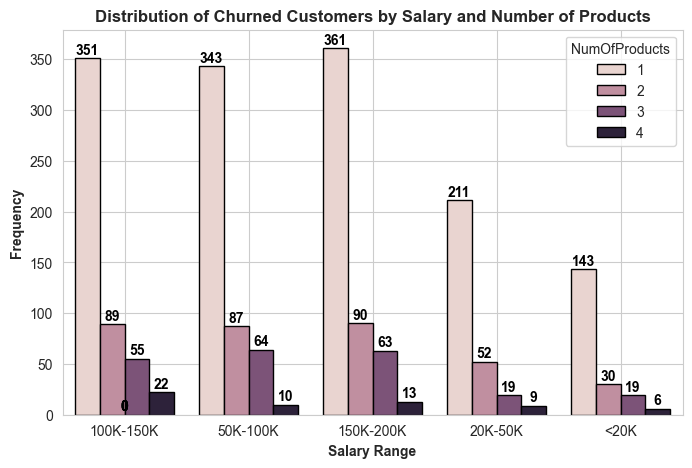

In [22]:
new_df =df[df["Exited"]==1]
count=df["Salary Range"].value_counts(ascending=False)
order =count.index
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
ax=sns.countplot(data=new_df, x="Salary Range", palette=palette,hue="NumOfProducts",order=order,edgecolor="black")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", 
                va="baseline", 
                fontsize=10, 
                color="black", 
                xytext=(0, 3),
                textcoords="offset points",
                fontweight="bold")
plt.title("Distribution of Churned Customers by Salary and Number of Products", fontsize=12, fontweight="bold")
plt.xlabel("Salary Range", fontsize=10, fontweight="bold")
plt.ylabel("Frequency", fontsize=10, fontweight="bold")
plt.grid(True, linestyle="solid")
plt.show()

* Lets visualize **Churned customers salary distribution by location**

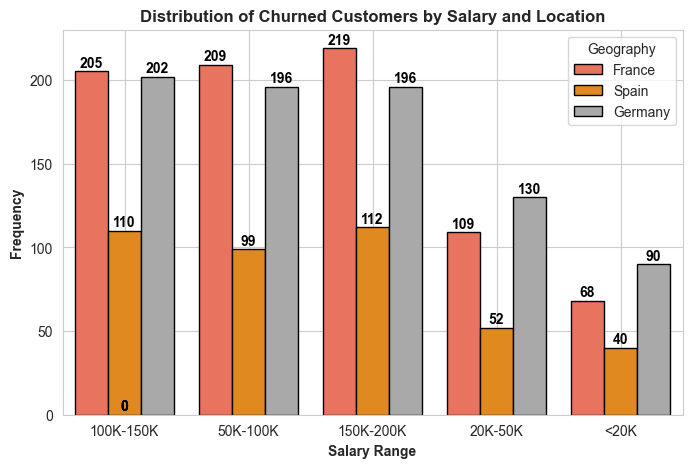

In [23]:
new_df =df[df["Exited"]==1]
count=df["Salary Range"].value_counts(ascending=False)
order =count.index
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
ax=sns.countplot(data=new_df, x="Salary Range",order=order,hue="Geography",edgecolor="black")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", 
                va="baseline", 
                fontsize=10, 
                color="black", 
                xytext=(0, 3),
                textcoords="offset points",
                fontweight="bold")
plt.title("Distribution of Churned Customers by Salary and Location", fontsize=12, fontweight="bold")
plt.xlabel("Salary Range", fontsize=10, fontweight="bold")
plt.ylabel("Frequency", fontsize=10, fontweight="bold")
plt.grid(True, linestyle="solid")
plt.show()

* Lets visualize **churn rate distribution by salary and age group**

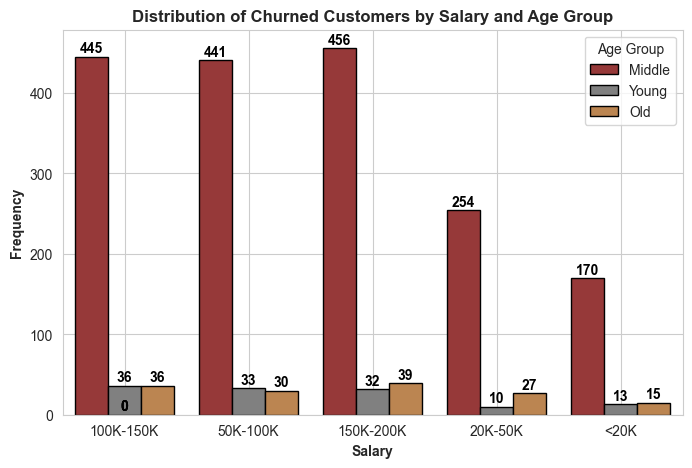

In [24]:
new_df =df[df["Exited"]==1]
count=df["Salary Range"].value_counts(ascending=False)
order =count.index
sns.set_style("whitegrid")
palette =sns.set_palette(["brown","gray","peru"])
plt.figure(figsize=(8,5))
ax=sns.countplot(data=new_df, x="Salary Range",order=order,hue="Age Group",edgecolor="black")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", 
                va="baseline", 
                fontsize=10, 
                color="black", 
                xytext=(0, 3),
                textcoords="offset points",
                fontweight="bold")
plt.title("Distribution of Churned Customers by Salary and Age Group", fontsize=12, fontweight="bold")
plt.xlabel("Salary", fontsize=10, fontweight="bold")
plt.ylabel("Frequency", fontsize=10, fontweight="bold")
plt.grid(True, linestyle="solid")
plt.show()

* Lets visualize **distribution of products by churn**

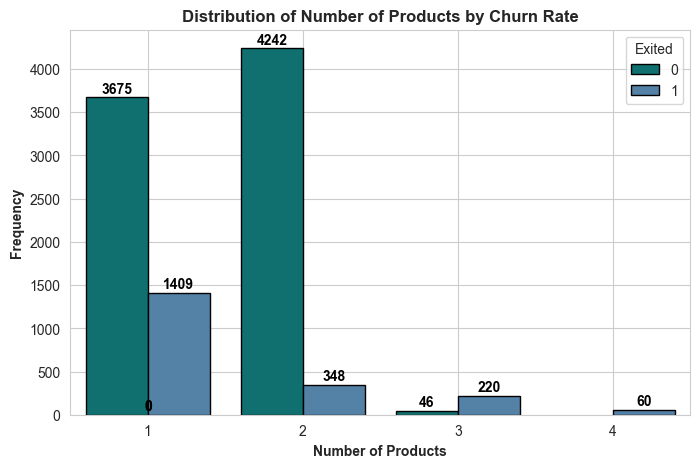

In [25]:
salary =df["NumOfProducts"].value_counts()
order=salary.index
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
palette =sns.set_palette(["teal","steelblue"])
ax =sns.countplot(data=df, x="NumOfProducts", order=order,hue="Exited", edgecolor="black")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha="center",
               va="baseline",
               fontsize=10,
               color="black",
               xytext=(0,3),
               textcoords= "offset points",
               fontweight ="bold")
plt.title("Distribution of Number of Products by Churn Rate", fontsize=12, fontweight="bold")
plt.xlabel("Number of Products", fontweight="bold", fontsize=10)
plt.ylabel("Frequency", fontweight="bold", fontsize=10)
plt.grid(True, linestyle="solid")    

* Lets **visualize age churn rate**

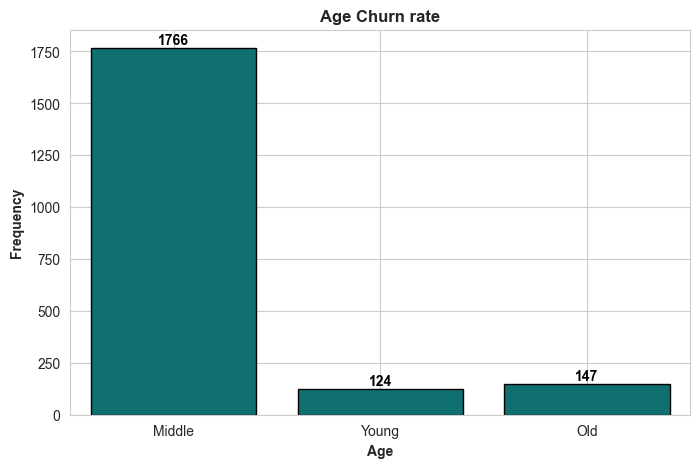

In [26]:
new_df=df[df["Exited"]==1]
salary =df["Age Group"].value_counts()
order=salary.index
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
ax =sns.countplot(data=new_df, x="Age Group", order=order, edgecolor="black")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha="center",
               va="baseline",
               fontsize=10,
               color="black",
               xytext=(0,3),
               textcoords= "offset points",
               fontweight ="bold")
plt.title("Age Churn rate", fontsize=12, fontweight="bold")
plt.xlabel("Age", fontweight="bold", fontsize=10)
plt.ylabel("Frequency", fontweight="bold", fontsize=10)
plt.grid(True, linestyle="solid")    

### Summary statistics

In [27]:
#summary stats of numerical features
stats =df[["CreditScore","Age","Tenure","Balance","NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary"]].describe()
display(stats)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000


In [28]:
#for categorical features
stats =df[["Gender","Geography"]].describe()
display(stats)

,Gender,Geography
count,10000,10000
unique,2,3
top,Male,France
freq,5457,5014


### Insights
* The highest churned customers are from France and Germany particularly in the middle age group and those with medium to high credit scores.
* One thing to note is female customers have a slightly higher churn rate than male customers.
* Customers with one product are more likely to churn compared to those with two or more products.
* Salary also seems to play a role in churn with middle aged customers earning between 100k to 150K showing higher churn.
* The highest number of churned customers occurs at 1 year of tenure indicating many customers tend to exit shortly after their first year with the bank.
* From our tenure bar plot,highest churn for both genders happens at tenure 1 year, with 130 females and 102 males leaving the bank suggesting that a significant number of customers churn in their early years with the bank.
* Customers who have stayed for over 10 years have relatively low churn numbers compared to other tenures, suggesting that customers who stay for 10 years are more likely to remain loyal.
* Tenure 0 has the lowest churn rates for both genders, with only 55 females and 40 males. This might suggest that very new customers tend to give the bank more time before leaving.
* From the summary statistics and given the higher proportion of male customers and those in France, targeted marketing strategies could be tailored for these segments.
* Understanding the characteristics of churned customers can help in developing better retention strategies, especially focusing on those with shorter tenures and lower credit scores.
* Providing financial education and advisory services may also assist customers in increasing their balances and engaging more with the bank oftenly.
* There is a wide range of credit scores, suggesting that the bank serves both high- and low-credit customers.
* The customer base consists of both young and older individuals, with tenure clustering around the 3–7 year range and many customers have zero balances which could indicate inactive or new accounts.
Churn rate of 20% tells us we need to focus on improving customer retention, particularly among customers with low tenure and those who are inactive.
* Looking at products most customers use only 1 or 2 products, suggesting potential for cross selling additional services to customers.

#### Lets plot histograms and boxplots to understand the distribution of our features

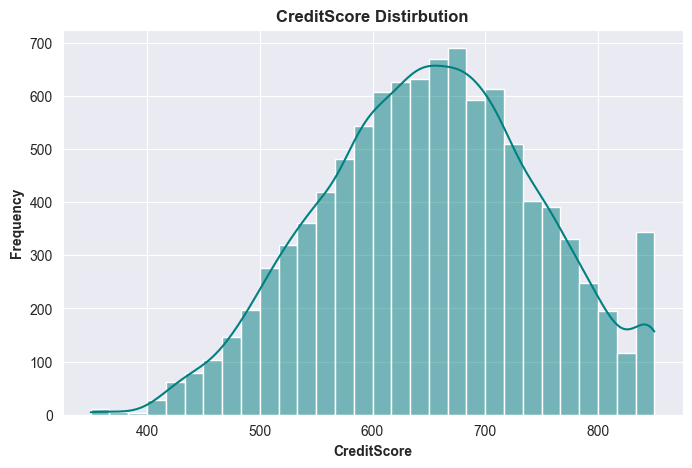

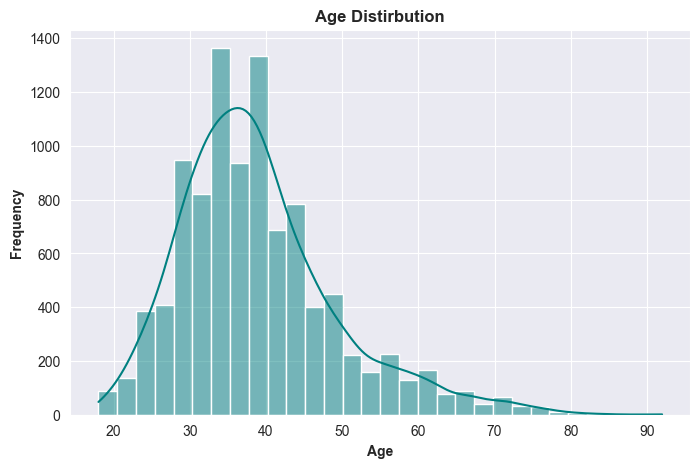

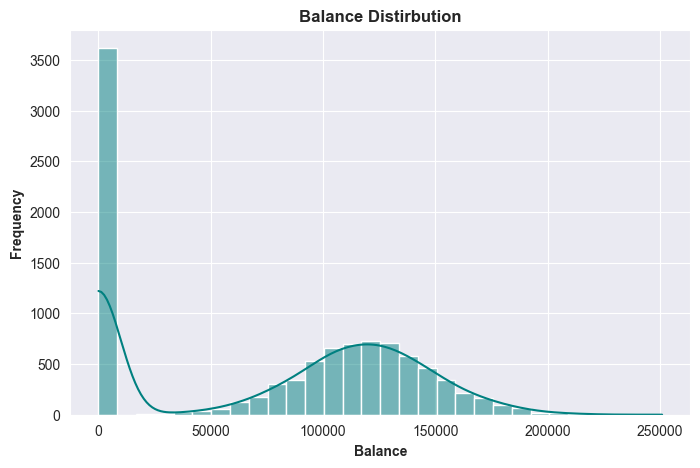

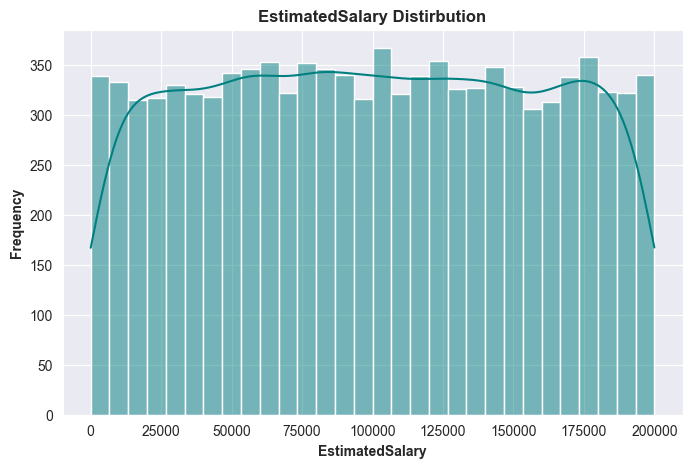

In [29]:
sns.set_style("darkgrid")
for feature in df[["CreditScore","Age","Balance","EstimatedSalary"]]:
    plt.figure(figsize=(8,5))
    sns.histplot(df[feature], bins=30, color ="teal",kde=True)
    plt.title(f"{feature} Distirbution",fontsize =12,fontweight="bold")
    plt.xlabel(feature,fontweight="bold")
    plt.ylabel("Frequency", fontweight="bold")
    plt.grid(True, linestyle= "solid")
    plt.show()

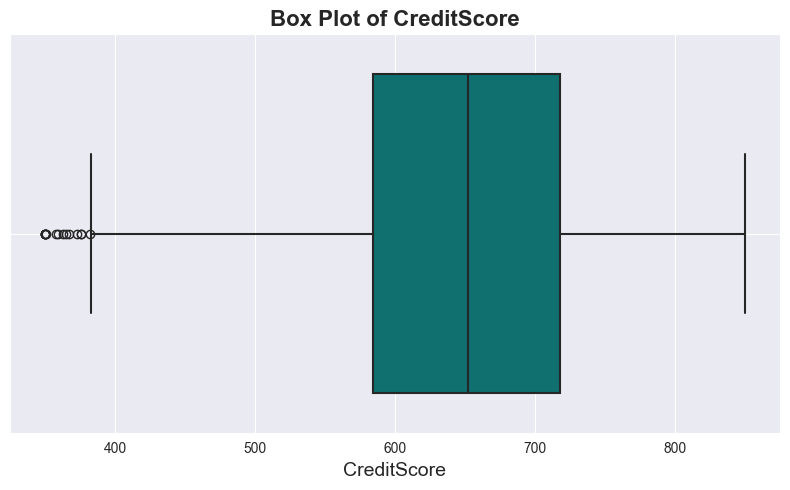

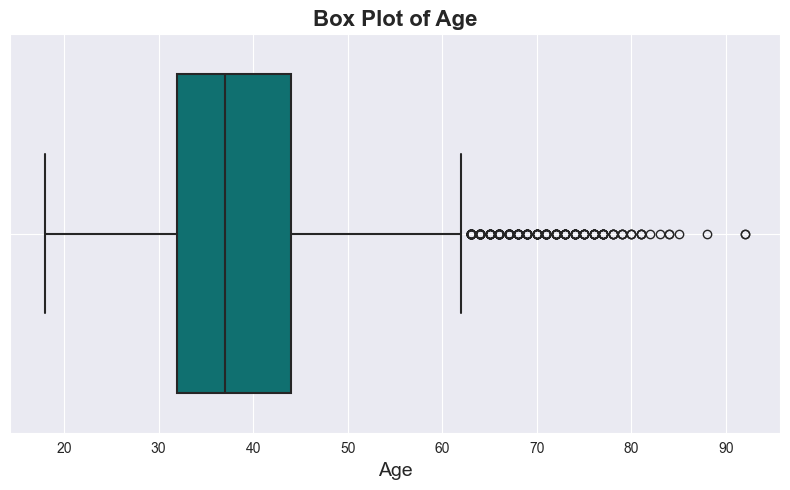

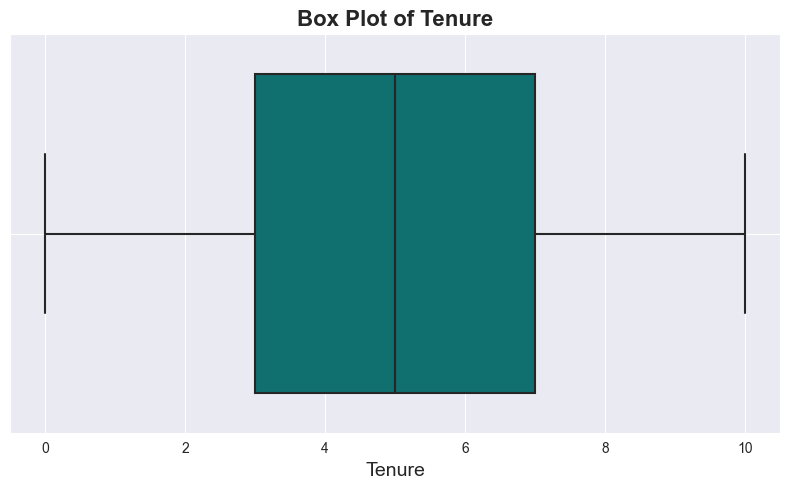

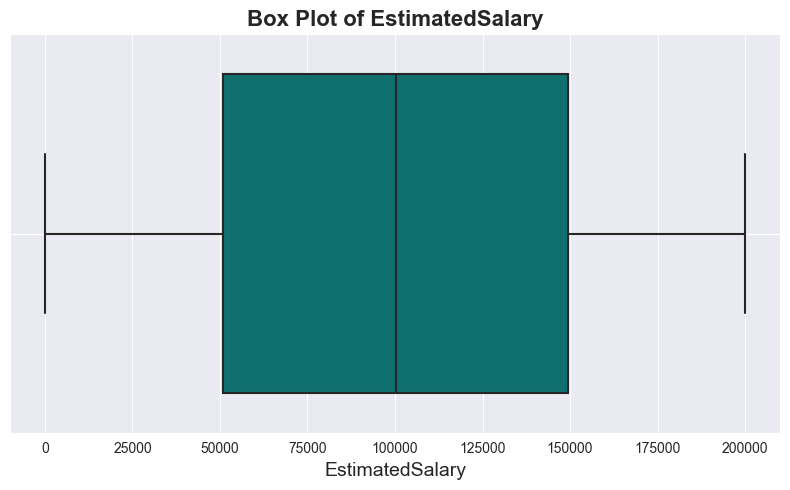

In [30]:
sns.set_style("darkgrid")
for feature in ["CreditScore","Age","Tenure","EstimatedSalary"]:
    plt.figure(figsize=(8, 5))  # Increase figure size for readability
    sns.boxplot(x=df[feature], color="teal", linewidth=1.5)  # Thicker lines for more definition
    plt.title(f'Box Plot of {feature}', fontsize=16, fontweight="bold")
    plt.xlabel(feature, fontsize=14)
    plt.grid(True,linestyle="solid")
    plt.tight_layout()
    plt.show()

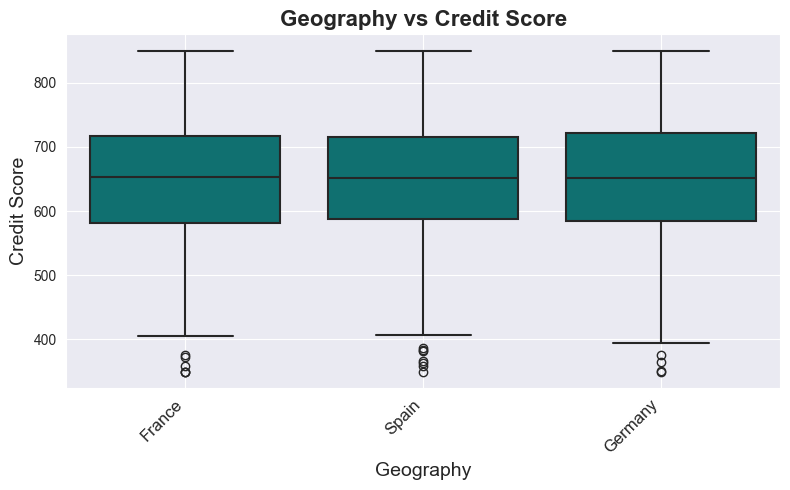

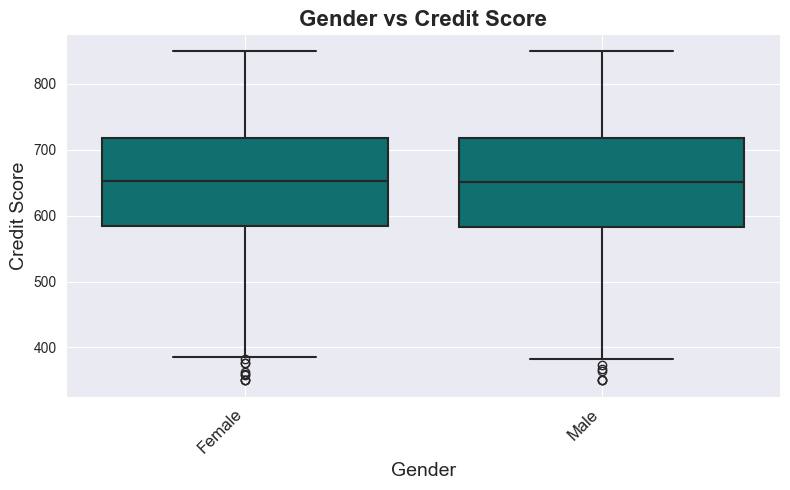

In [31]:
#lets plot boxplots for the categorical features
sns.set_style("darkgrid")
for feature in ["Geography","Gender"]:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df,x=df[feature],y="CreditScore",linewidth=1.5,color="teal")
    plt.xticks(rotation=45, ha="right",fontsize=12)
    plt.title(f"{feature} vs Credit Score", fontsize=16, fontweight="bold")
    plt.xlabel(feature, fontsize=14)
    plt.ylabel("Credit Score", fontsize=14)
    plt.grid(True, linestyle="solid")
    plt.tight_layout()
    plt.show()

### A correlation matrix of our features

In [32]:
#getting the correlation
numerical_features =["CreditScore","Age","Tenure","Balance","NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary","Exited"]
display(df[numerical_features].corr())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


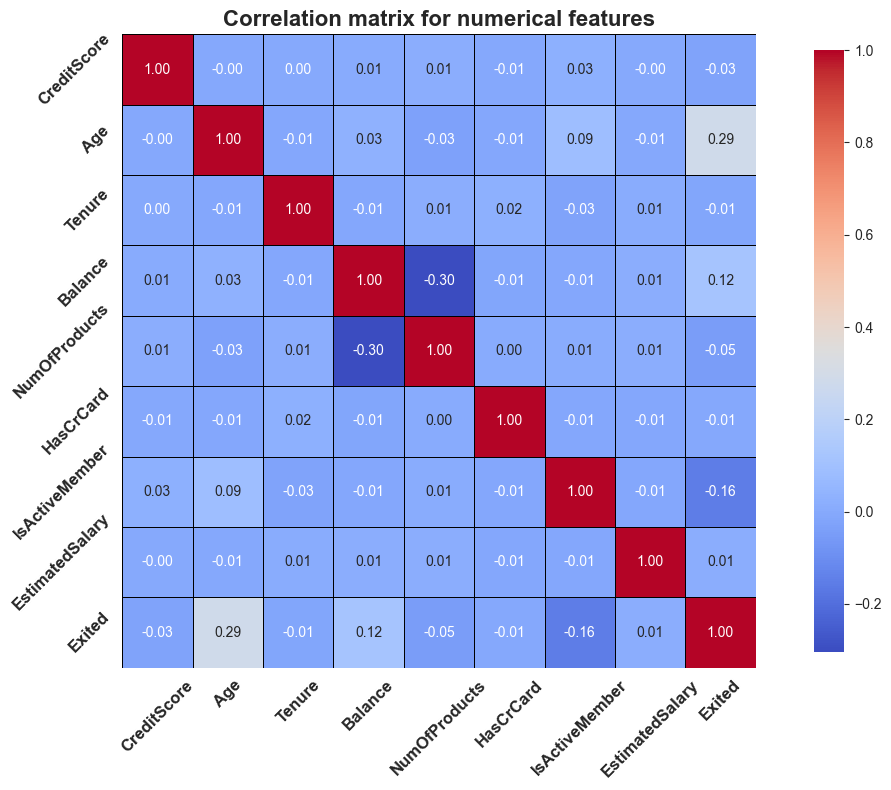

In [33]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_features].corr(), 
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            linewidths=0.5, 
            linecolor="black",
            square=True, 
            cbar_kws={"shrink": 0.95}
) 
plt.title("Correlation matrix for numerical features", fontsize=16, fontweight="bold")
plt.xticks(fontsize=12, rotation=45, fontweight="bold")
plt.yticks(rotation=45,fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

### Key Findings:
One thing to note is that our features are well distributed and there is no multicollinearity.

**Age and Exited (0.285):**
Age has a moderate positive correlation with customer churn whereby initially we noticed older customers are more likely to churn.

**Balance and Exited (0.118):**
Balance shows a slight positive correlation with churn, meaning customers with higher balances are  more likely to churn.

**IsActiveMember and Exited (-0.156):**
This negative correlation tells us that Active customers are less likely to churn compared to the non Active members.

**NumOfProducts and Balance (-0.304):**
There is a strong negative correlation between the number of products and balance indicating that customers with more products tend to have lower balances.

**NumOfProducts and Exited (-0.048):**
The number of products has a weak negative correlation with churn suggesting that customers with more products are slightly less likely to churn, though this effect is small.

**CreditScore and Exited (-0.027):**
Credit score has a very weak negative correlation with churn meaning customers with higher credit scores are slightly less likely to churn though the effect is minimal.

**Age and Balance (0.028):**
Age and balance have a weak positive correlation meaning older customers tend to have slightly higher balances.
HasCrCard and Exited (-0.007):
Having a credit card has almost no correlation with churn indicating that credit card usage is not a significant factor in determining customer churn.
## Assumptions
* We can conclude that Age is the most influential factor related to churn with older customers more likely to exit and active membership reduces churn significantly.
* As we had seen earlier,balance of accounts correlates slightly with churn as higher balances show a small tendency towards a customer exiting the bank.

# Modeling
We are done with Exploring the data and made the assumption that Age is the most influential factor in determining whether a customer exits or not. Now we will build some classification models and see if indeed Age drives customers churn rate.
* I will begin with the most common model used for classification problem, a **Logistic regression**
## A Tuned Logistic regression

In [34]:
#lets subset our features
X =df[["CreditScore","Geography","Gender","Age","Tenure","Balance","NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary"]]
y =df["Exited"]

In [35]:
#lets do some  encoding on the Gender and Geography
encoder =LabelEncoder()
X.loc[:,"Gender"] =encoder.fit_transform(df["Gender"])
X =pd.get_dummies(X, columns =["Geography"],drop_first=False)
#lets check if there are missing values
print(f"\nMissing values present: {X.isna().any()}")


Missing values present: CreditScore          False
Gender               False
Age                  False
Tenure               False
Balance              False
NumOfProducts        False
HasCrCard            False
IsActiveMember       False
EstimatedSalary      False
Geography_France     False
Geography_Germany    False
Geography_Spain      False
dtype: bool


In [36]:
#lets split our dataset
X_train,X_test,y_train,y_test =train_test_split(
    X,y,test_size =0.25,random_state=42
)

print(f"\nX_train shape: {X_train.shape}")
print(f"\nX_test shape: {X_test.shape}")
print(f"\ny_train shape: {y_train.shape}")
print(f"\ny_test shape: {y_test.shape}")
#lets display our new dataset
X.head()


X_train shape: (7500, 12)

X_test shape: (2500, 12)

y_train shape: (7500,)

y_test shape: (2500,)


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,True,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,False,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,True,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,True,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,False,False,True


In [37]:
#lets standardize our features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
#building the model
model = LogisticRegression(max_iter=500)
param_grid = {
    "C": [0.1, 1, 10],
    "solver": ["liblinear", "lbfgs"]
}
GCV = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")
GCV.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = GCV.best_params_
print(f"Best params: {best_params}")

Best params: {'C': 1, 'solver': 'lbfgs'}


In [38]:
#lets build our final model with the best parameters
final_model = LogisticRegression(C=1, solver="lbfgs", max_iter=500)
final_model.fit(X_train_scaled, y_train)

LogisticRegression(C=1, max_iter=500)

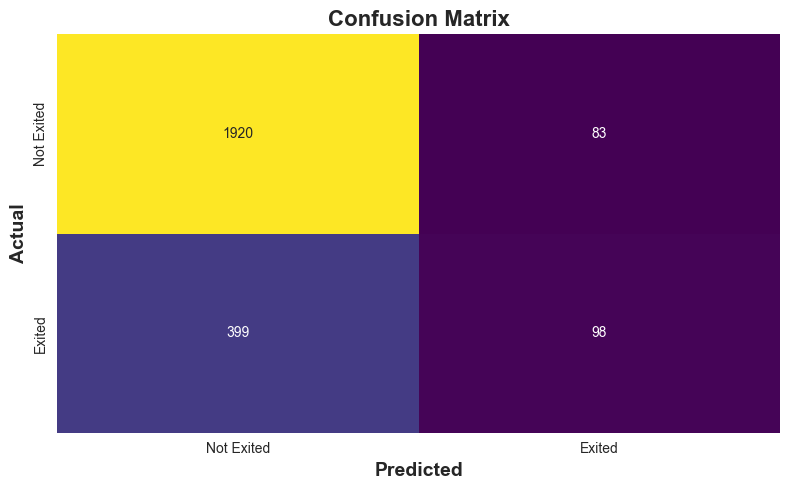


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2003
           1       0.54      0.20      0.29       497

    accuracy                           0.81      2500
   macro avg       0.68      0.58      0.59      2500
weighted avg       0.77      0.81      0.77      2500



In [39]:
#lets make predictions
y_pred =final_model.predict(X_test_scaled)

#lets visualize a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="viridis",
    cbar=False,
    xticklabels=["Not Exited","Exited"], 
    yticklabels=["Not Exited","Exited"]
)
plt.ylabel("Actual", fontsize=14,fontweight="bold")
plt.xlabel("Predicted", fontsize=14,fontweight="bold")
plt.title("Confusion Matrix", fontsize=16,fontweight="bold")
plt.tight_layout()
plt.show()

#ploting classification report
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

AUC: 0.77


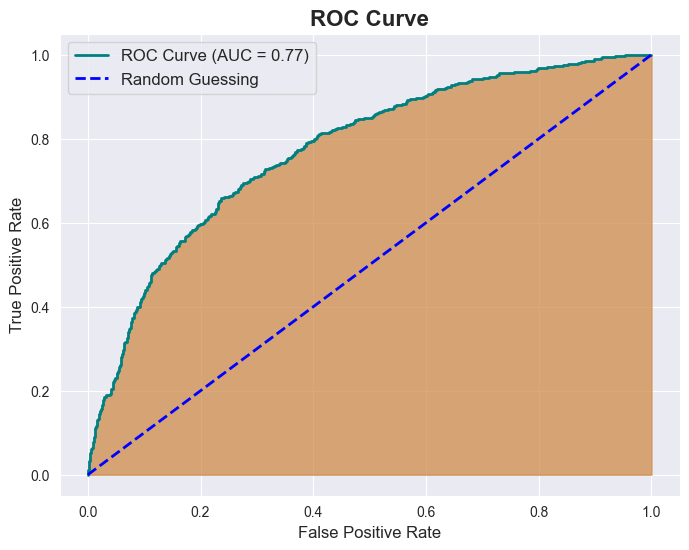

In [40]:
#lets calculate the AUC
y_prob = final_model.predict_proba(X_test_scaled)[:, 1]  
roc_auc_score_val = roc_auc_score(y_test, y_prob)
print(f"AUC: {roc_auc_score_val:.2f}")

#assigning false positive and true positive rates and a threshold
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

#lets plot a ROC curve and a random guessing line
sns.set_style("darkgrid")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="blue", lw=2, linestyle="--", label="Random Guessing")
plt.fill_between(fpr, tpr, alpha=0.7,color="peru")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve", fontsize=16,fontweight="bold")
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc="upper left", fontsize=12) 
plt.show()

#### Accuracy Score
0.81 is a decent overall accuracy suggesting that the model performs well in general. However, accuracy is a straight forward metric, its not suitable for imbalanced datasets.
#### Confusion Matrix
* True Negatives (TN): 1920 This tells us that model has correctly predicted 1920 customers who will not churn.
* False Positives (FP): 83 This tells us that model has incorrectly predicted 83 customers to churn.
* False Negatives (FN): 399 This tells us that our model has incorrectly predicted 399 customers to not churn.
* True Positives (TP): 98 This tells us that our model has correctly predicted 98 customers to churn.
* This matrix indicates that the model is better at predicting non churning customers than churning customers. The high number of false negatives;399 suggests that many customers who did churn were not correctly identified by the model.

### Classification Report
* Precision (for class 1): 0.54 indicates that when the model predicts churn, it is correct about 54% of the time.
* Recall (for class 1): 0.20 indicates that only 20% of actual churners are correctly identified.
* F1-score (for class 1): 0.29 is low, indicating that the model struggles to balance precision and recall for this class.
The macro averages suggest that the model performs better for class 0 than class 1, reflecting class imbalance in your dataset.

The **AUC** is 0.77 suggesting that the model has a good ability to distinguish between the two classes overall, but there is room for improvement, especially in predicting class 1.

* Lets try a **Tuned K-Neighbors Classifier** and see how it performs

## A Tuned K-Neighbors Classifier

In [41]:
#lets standardize our features
scaler =StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"]
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'n_neighbors': 11, 'weights': 'distance'}


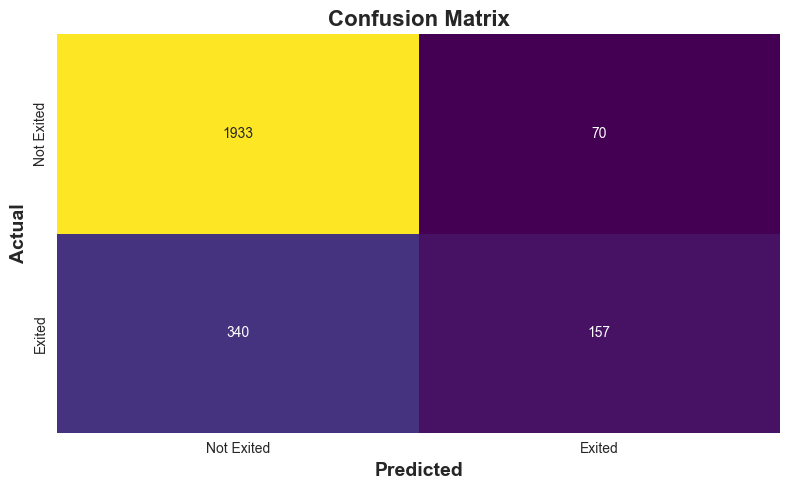


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      2003
           1       0.69      0.32      0.43       497

    accuracy                           0.84      2500
   macro avg       0.77      0.64      0.67      2500
weighted avg       0.82      0.84      0.81      2500

AUC: 0.80


In [43]:
#lets build our best model
best_knn =KNeighborsClassifier(n_neighbors=11, weights="distance")
best_knn.fit(X_train,y_train)
#lets make some predictions
y_pred = best_knn.predict(X_test)
#lets visualize a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="viridis",
    cbar=False,
    xticklabels=["Not Exited","Exited"], 
    yticklabels=["Not Exited","Exited"]
)
plt.ylabel("Actual", fontsize=14,fontweight="bold")
plt.xlabel("Predicted", fontsize=14,fontweight="bold")
plt.title("Confusion Matrix", fontsize=16,fontweight="bold")
plt.tight_layout()
plt.show()

#ploting the classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

#calculating AUC
y_pred_proba = best_knn.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.2f}")

#### Accuracy Score
This means that 84% of the total predictions made by your model were correct.
#### Confusion matrix
* True Negatives (TN): 1933 (Correctly predicted customers who did not churn)
* False Positives (FP): 70 (Incorrectly predicted customers who did not churn)
* False Negatives (FN): 340 (Incorrectly predicted customers who churned)
* True Positives (TP): 157 (Correctly predicted customers who churned)
#### Precision
For of all predicted non churns 85% were correct and for of all predicted churns 69% were correct.
#### Recall
* The model correctly identified 97% of actual non-churns.
* For class 1 ,the model only identified 32% of actual churns. This indicates that the model struggles to detect churners, leading to a higher number of false negatives.
#### F1-Score
For class 0 0.90 indicates a good balance between precision and recall while 0.43 for class 1 indicates that while precision is decent, recall is quite low resulting in a poor F1-score.
The **AUC** value of 0.80 suggests that the model has a good ability to distinguish between the two classes.
### Overall Insights
The model performs well at predicting Non churn customers but struggles with predicting churned customers.
The high false negative rate for churn means that many customers who will likely leave are being misclassified, which can be critical for business decisions hence will try another model.

## A Tuned Random Forest

In [44]:
param_grid = {
    "n_estimators": [50, 100, 200],        
    "max_features": [None, "sqrt"],     
    "max_depth": [None, 10, 20, 30],       
    "min_samples_split": [2, 5, 10],      
    "min_samples_leaf": [1, 2, 4],        
    "bootstrap": [True, False]  
}
# Instantiate the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5, 
    scoring="accuracy",
    verbose=2, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [45]:
# Instantiate the model with the best parameters
best_rf = RandomForestClassifier(
    bootstrap=True, 
    max_depth=None, 
    max_features="sqrt", 
    min_samples_leaf=4, 
    min_samples_split=10, 
    n_estimators=100,
    random_state=42
)
# Train the model on the training data
start =time.time()
best_rf.fit(X_train, y_train)
end =time.time()
training_time = end - start
print(f"Training time: {training_time:.2f} seconds")

#lets  do predictions on the test data
y_pred = best_rf.predict(X_test)

Training time: 1.57 seconds


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2003
           1       0.78      0.47      0.59       497

    accuracy                           0.87      2500
   macro avg       0.83      0.72      0.75      2500
weighted avg       0.86      0.87      0.86      2500


Cross-validated accuracy: 0.86


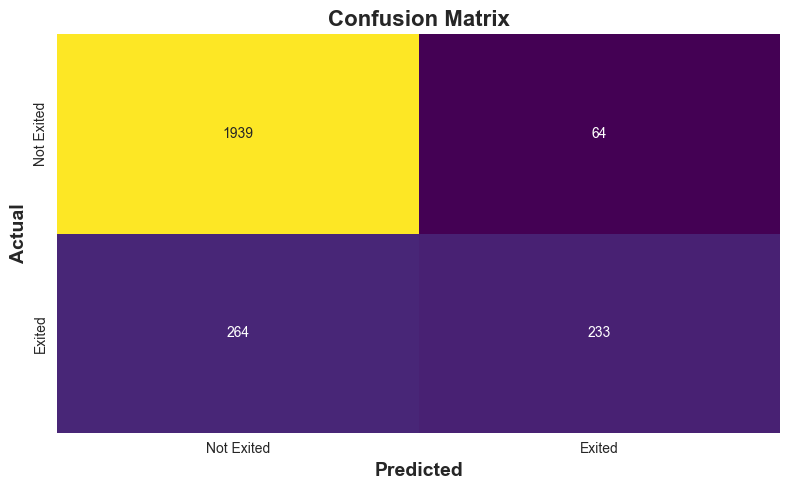

In [46]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

#lets do a cross validation
scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validated accuracy: {np.mean(scores):.2f}")

#lets visualize a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="viridis",
    cbar=False,
    xticklabels=["Not Exited","Exited"], 
    yticklabels=["Not Exited","Exited"]
)
plt.ylabel("Actual", fontsize=14,fontweight="bold")
plt.xlabel("Predicted", fontsize=14,fontweight="bold")
plt.title("Confusion Matrix", fontsize=16,fontweight="bold")
plt.tight_layout()
plt.show()

#### Overall Accuracy
The model was able to correctly predict 87% of the total predictions which is a good thing.
#### Not churn(class 0)
A Precision of 0.88 tells us that when the model predicts class 0, it is correct 88% of the time and Recall of 0.97 shows the model correctly identified 97% of the true class 0 instances.F1-score of 0.92 This is the harmonic mean and shows a strong overall performance for class 0.
#### Churn(class 1)
The Precision 0.78 indicates the model predicts class 1, it is correct 78% of the time and Recall of 0.47 tells us that the model only identified 47% of the true class 1 instances.F1-score 0.59 suggests the model struggles with accurately predicting class 1.
### Insight
* The model is very good at predicting the majority class (class 0).
* The model struggles with the minority class (class 1), as evidenced by the low recall (0.47), indicating it's missing a significant number of class 1 instances. Lets try an XGBClassifier and see how it performs

## A Tuned XGBClassifier

In [47]:
#lets define our target variable and features
X =df[["CreditScore","Geography","Gender","Age","Tenure","Balance","NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary"]]
y =df["Exited"]

In [48]:
categorical_features =["Geography","Gender"]
ohe =OneHotEncoder(sparse_output=False)
X_encoded = pd.DataFrame(
    ohe.fit_transform(X[categorical_features]),
    columns=ohe.get_feature_names_out(categorical_features),
    index=X.index
)
#lets drop the original categorical columns and concatenate the encoded columns
X = X.drop(categorical_features, axis=1)
X = pd.concat([X, X_encoded], axis=1)
y= y.loc[X.index]

print(f"The shape of the features: {X.shape}")
print(f"The shape of the target: {y.shape}")
display(X.head())
display(y.head())

The shape of the features: (10000, 13)
The shape of the target: (10000,)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0,1.0,0.0
1,608,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0,1.0,0.0
2,502,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0,1.0,0.0
3,699,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0,1.0,0.0
4,850,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0,1.0,0.0


0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int32

In [49]:
#lets do the splitting
X_train,X_test,y_train,y_test =train_test_split(
    X,y,test_size =0.25,random_state =42
)
#parameters for the model
model_params = {
    "objective": "binary:logistic", 
    "eval_metric": "logloss"
}
#defining our hyperparameters
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}
xgb_model = xgb.XGBClassifier(**model_params,use_label_encoder=False)
#performing grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=2,n_jobs=-1, scoring="accuracy")
start =time.time()
grid_search.fit(X_train, y_train)
end =time.time()
training_time =end - start
print(f"Training time {training_time:.2f}")

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Training time 1551.65


In [50]:
best_params = grid_search.best_params_
print(f"\nBest Estimator Parameters: {best_params}")

best_score = grid_search.best_score_
print(f"\nBest Cross-Validation Score: {best_score}")
#lets take our best model
best_model = grid_search.best_estimator_


Best Estimator Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}

Best Cross-Validation Score: 0.8632


In [51]:
#making predictions on the test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2003
           1       0.78      0.49      0.60       497

    accuracy                           0.87      2500
   macro avg       0.83      0.73      0.76      2500
weighted avg       0.86      0.87      0.86      2500



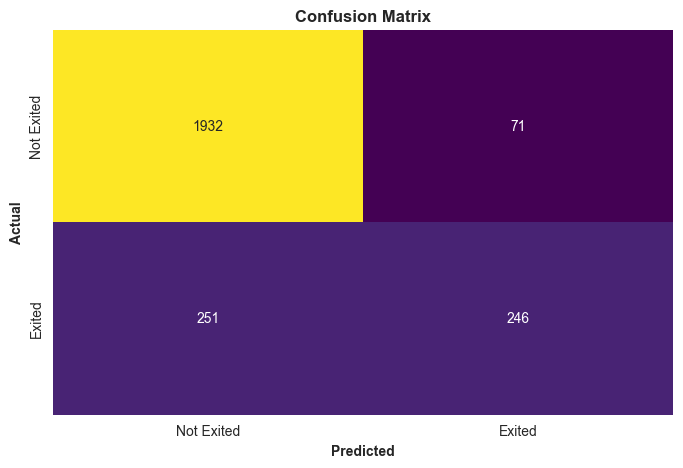

In [53]:
#printing the classification report
print(classification_report(y_test, y_pred))
#generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#lets visualize the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="viridis", 
    cbar=False,
    xticklabels=["Not Exited", "Exited"], 
    yticklabels=["Not Exited", "Exited"]
)
plt.ylabel("Actual",fontweight="bold")
plt.xlabel("Predicted",fontweight="bold")
plt.title("Confusion Matrix",fontweight="bold",fontsize=12)
plt.show()

AUC Score: 0.87


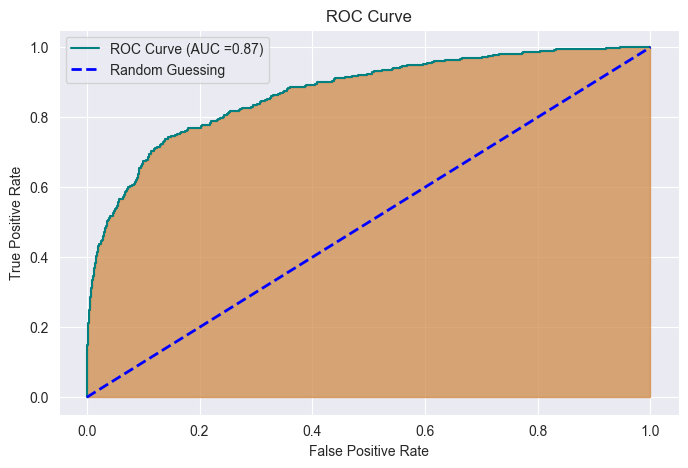

In [54]:
#lets get the ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test,y_prob)
print(f"AUC Score: {roc_auc:.2f}")
#lets the ROC curve
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC ={roc_auc:.2f})")
plt.fill_between(fpr, tpr, alpha=0.7,color="peru")
plt.plot([0, 1], [0, 1], color="blue", lw=2, linestyle="--",label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.legend(loc="upper left")
plt.show()

#### Overall Accuracy
The model was able to correctly predict 87% of the total predictions which is a good thing.
#### Not churn(class 0)
The Precision of 0.89 tells us that when the model predicts class 0, it is correct 89% of the time while Recall of 0.96 shows us the model correctly identified 96% of the true class 0 instances.
F1-score of 0.92 is the harmonic mean of precision and recall and it indicates a strong overall performance for class 0.
#### Churn(class 1)
A Precision of 0.78 tells us when the model predicts class 1, it is correct 78% of the time while Recall of 0.49 tells model only identified 47% of the true class 1 instances.
F1-score of 0.60 suggests the model struggles with accurately predicting class 1.
### Insights
Our model is moderately struggling again to predict customers who will churn. The recall for class 1 is only 0.49, meaning that the model misses about half of the actual churners. This is a critical issue because accurately identifying churners is often the goal in bank churn prediction.

## Threshold Adjustment
At the start of this project we defined our main objective as building a model that can predict customers that are likely to churn. For us to achieve this, the recall for class 1 (churners) should be a key metric as it measures how many of the actual churners are identified by the model.
Lets adjust the decision threshold for predicting churn class 1 to increase recall for churners at the cost of some precision. The threshold at default is usually 0.5 we'll try and iterate till we get our right threshold.

In [55]:
y_prob = best_model.predict_proba(X_test)
# subsetting probabilities for class 1
y_prob_churn = y_prob[:, 1]

* Since we are unsure on which threshold to use, lets automate the process by iterating over a range of thresholds and selecting the one that maximizes a particular metric

In [56]:
#lets find f1_score for multiple thresholds
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = [f1_score(y_test, (y_prob_churn >= t).astype(int)) for t in thresholds]
#getting the best threshold
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold for maximum F1-score: {best_threshold}")
#using the best threshold to make predictions
y_pred_best = (y_prob_churn >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_best))

Best threshold for maximum F1-score: 0.28
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      2003
           1       0.60      0.70      0.65       497

    accuracy                           0.85      2500
   macro avg       0.76      0.79      0.78      2500
weighted avg       0.86      0.85      0.85      2500



### Summary:
After adjusting the threshold to 0.28:
* Precision for Class 0 (Non-churners): 0.92
* Recall for Class 0: 0.89
* F1-Score for Class 0: 0.90
* Precision for Class 1 (Churners): 0.60
* Recall for Class 1: 0.70
* F1-Score for Class 1: 0.65
* Overall Accuracy 0.85
### Class 0 (No Churn)
Precision increased to 0.92 means that when the model predicts a customer will not churn, it is correct 92% of the time.
Recall decreased to 0.89 from 0.96, meaning that the model is now missing some non-churners (customers it previously identified as not churning).
The slight drop in F1-score from 0.92 to 0.90 is likely due to the trade-off from improving the recall of the churners (Class 1).
### Class 1 (Churned)
Precision decreased to 0.60 means the model is predicting some non-churners as churners.
Recall increased significantly to 0.70 which is a key improvement as the model is identifying 70% of churners, which is much better compared to the original 49%. This is crucial for business use cases where identifying customers at risk of churning is the goal.
F1-Score increased to 0.65 indicating an overall improvement in the balance between precision and recall for churners.
### Insights
* Improvement in Recall to 0.70 means the model is now identifying more customers who are actually going to churn, which is crucial in business contexts where preventing churn can lead to improved customer retention.
* The precision for churners dropped to 0.60 indicating the model is misclassifying more non churners as churners but looking at our obejctive this is acceptable.
* Overall F1 Score for Class 1 increased to 0.65 showing that the balance between precision and recall for churners has improved after threshold adjustment.

### Saving our model

In [57]:
# Save the model to a file
joblib.dump(best_model, "Tuned_XGBClassifier_model.pkl")
print("Model saved as 'Tuned_XGBClassifier_model.pkl'")

Model saved as 'Tuned_XGBClassifier_model.pkl'


In [58]:
#getting the feature importances
importances = best_model.feature_importances_
total_importance = np.sum(importances)
importance_percentages = np.round((importances / total_importance) * 100,2)
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance [%]': importance_percentages
})

display(importance_df.sort_values(by="Importance [%]", ascending= False).set_index("Feature").head(15))

,Importance [%]
Feature,
NumOfProducts,37.459999
IsActiveMember,13.130000
Age,13.030000
Geography_Germany,9.150000
Balance,5.060000
Gender_Male,4.270000
Gender_Female,3.650000
Geography_France,3.520000
Geography_Spain,3.320000


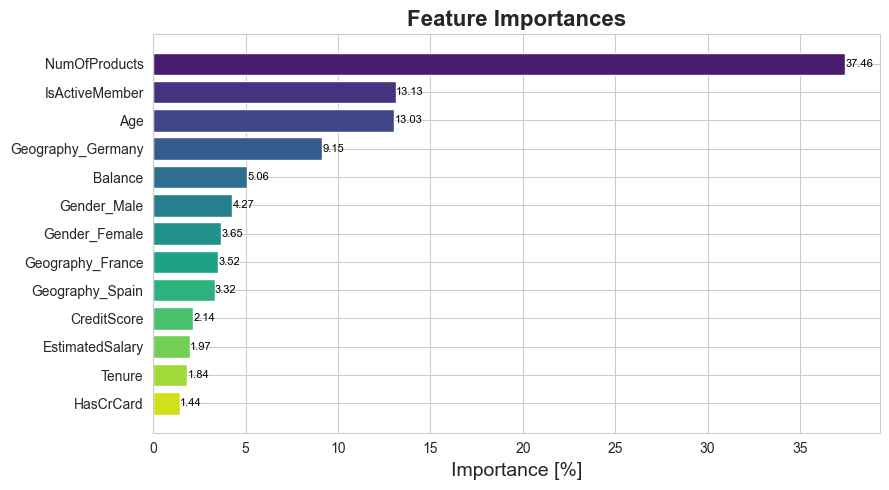

In [59]:
sns.set_style("whitegrid")
#sns.set_style("whitegrid")
importance_df = importance_df.sort_values(by="Importance [%]", ascending=False)
plt.figure(figsize=(9, 5))
ax = plt.barh(importance_df["Feature"], importance_df["Importance [%]"], color=sns.color_palette("viridis", n_colors=len(importance_df)))
plt.gca().invert_yaxis()
#Annotating bars with values
for i in ax.patches:
    plt.text(i.get_width() + 0.02,
             i.get_y() + i.get_height()/2., 
             f"{i.get_width():.2f}", 
             va="center",
             ha="left", 
             fontsize=8, 
             color="black")
plt.xlabel("Importance [%]", fontsize=14)
plt.title("Feature Importances", fontsize=16, fontweight="bold")
plt.grid(axis="x", linestyle="solid")
plt.tight_layout()
plt.show()

### Communication to Shareholders
We aimed to predict bank customer churn to understand the underlying reasons and prevent future losses and our model was able to identify the most critical factors driving churn.
### Key features
* NumOfProducts (37.46%): Customers with more bank products were less likely to churn indicating there is a need to offer more additional services and maybe cross selling relevant products.
* Is ActiveMember (13.13%): Active customers were much less likely to churn, indicating that engaging with customers regularly is essential.
* Age (13.03%): Older customers tend to be more loyal while younger customers exhibited a higher likelihood of churn thus tailoring engagement strategies based on age group might help.
* Geography (Germany 9.15%): Customers in especially Germany were more likely to churn hence we need to get a better understanding of regional differences in customer behavior.
Balance (5.05%): Customers with higher account balances were less likely to churn, signifying the importance of maintaining strong financial relationships with the customers.
### Recommendations
Based on the analysis and model results, we can recommend the following steps;
* Enhance Customer Engagement Programs

Focus on increasing the activity levels of current customers like starting an initiative that encourages frequent use of services like sending personalized offers, discounts or rewards for using specific products can significantly reduce churn especially for inactive customers.

* Cross Sell and Increase Products
  
There is a need to expand the range of products offered by the bank since customers using multiple products are far less likely to leave. Developing strategies to cross sell products based on customer needs focusing on low product customers who are more likely to churn.

* Retention Strategies for High Risk Groups

We noted that customers in Germany showed a higher propensity to churn hence developing specific regional marketing campaigns to address issues relevant to those regions can help in customer retention.
For younger customers we can try introducing more digital banking solutions or loyalty programs that can attract them so as to reduce the churn rate.

* Financial Incentives for High Balance Customers
  
We saw that customers with higher balances tend to remain loyal we can offer special financial incentives or wealth management programs to retain and further engage these customers.
### Conclusion
Focusing on the number of products used, customer activity levels,targeted regional and demographic strategies the bank can effectively lower churn rates and retain high value customers.
When these strategies are implemented we can expect a significant reduction in churn rates, improved customer satisfaction and overall growth in customer lifetime value.